In [1]:
# import the necessary packages
from matplotlib import pyplot as plt
import cv2
# import openflexure_microscope_client
import numpy as np
import os
import time
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import math
import scatter
from PIL import Image
import pickle

# %matplotlib qt
%matplotlib inline

In [7]:
with open(r'scans\14\export.pkl', 'rb') as f:
    imported = pickle.load(f)


print(imported['pairs'].keys())
print(f'0, 1' in list(imported['pairs'].keys()))

dict_keys(['0, 1', '1, 2', '2, 3', '3, 4'])
True


In [2]:
import sys
sys.path.insert(0, r'C:\Users\Administrator\Source\openflexure-microscope-pyclient')
import openflexure_microscope_client

Connect to the microscope. if you know the IP address of the microscope, include it here

If not, you can comment that line out, and uncomment the find_first_microscope line to automatically connect

In [3]:
def jpg_image_to_array(image_path):
  """
  Loads JPEG image into 3D Numpy array of shape 
  (width, height, channels)
  """
  with Image.open(image_path) as image:         
    im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
    im_arr = im_arr.reshape((image.size[1], image.size[0], 3))                                   
  return im_arr

image_parameters = {"use_video_port": False}

microscope = openflexure_microscope_client.MicroscopeClient("10.120.33.184")
# microscope = openflexure_microscope_client.find_first_microscope()
pos = microscope.position
starting_pos = pos.copy()

We need a background image to compare all images to. The ideal background image will have some variation (light / dark areas) to properly represent the range of backgrounds

If you want to capture a new image, use the first two lines to move to a background area and capture an image.
If you have an example background saved locally, you can use the third line instead

In [4]:
m = microscope.move((0, 0, -6254))
# background = microscope.grab_image_array()
background = np.asarray(microscope.capture_image(params = {
            "use_video_port": True,
            "bayer": False,
        }))


Can look at the background image to make sure it doesn't contain any sample as required

In [5]:
plt.imshow(background)
plt.show()

In [6]:
# we're working in the LUV colourspace as it collect colours together in a human-intuitive way
background_LUV = cv2.cvtColor(background, cv2.COLOR_RGB2LUV)

ch1 = (background_LUV.T[0]).flatten()
ch2 = (background_LUV.T[1]).flatten()
ch3 = (background_LUV.T[2]).flatten()

points = np.array([np.asarray(ch1),np.asarray(ch2),np.asarray(ch3)]).T

# we get the mean and standard deviation of values in each channel

mu, std = np.apply_along_axis(norm.fit, 0, points)
stats_list = np.vstack([mu, std])

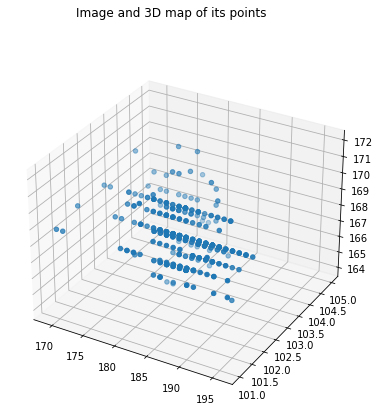

<Figure size 432x288 with 0 Axes>

In [7]:
fig = plt.figure()
fig.set_size_inches(14.5, 6.5)
fig.suptitle('Image and 3D map of its points')
ax = fig.add_subplot(1, 1, 1, projection='3d')
sample_rate = int(len(ch1) / 400)
ax.scatter(ch1[::sample_rate], ch2[::sample_rate], ch3[::sample_rate], label = 'background')
plt.show()

plt.close('all')
plt.clf()

In [8]:
def distance_to_site(current, next):
    return np.sqrt( (next[1] - current[1])**2 + (next[0] - current[0])**2 )

This is where your scan starts. Change the starting_pos, step_sizes, grid_size and scan_style to cover the area as normal.
Set sample_coverage to be the percent of the image that should look unlike the background for the FOV to be considered sample. I wouldn't go lower than around 3% here

In [9]:
# if necessary, move to the starting point for your scan
microscope.move((20000, 0, -8254))

scatter.looping_autofocus(microscope)

dx = 12000
dy = 6000
sample_coverage = 10

# construct a 2D scan path
path = [[microscope.position['x'], microscope.position['y']]]

# a list of the sites images have been taken at, and sites with a successful autofocus
focused_path = []
true_path = []

i = 0

start_time = time.strftime("%H_%M_%S-%d_%m_%Y")

# move to each x-y position. in z, move to the height of the closest x-y position that successfully focused
while len(path) > 0:
    loc = [path[0][0], path[0][1], microscope.position['z']]

    path.remove(loc[:2])

    microscope.move(loc)

    if len(focused_path) > 1:
        z_index = scatter.closest(loc, focused_path)
        # print('Moving to {0}'.format([coords[0], coords[1], focused_path[z_index][2]]))
        # print(focused_path)
        microscope.move((loc[0], loc[1], focused_path[z_index][2]))

    # capture an image, convert it to LUV, then make lists of the 3 channels' values
    img = microscope.grab_image_array()
    # img = np.asarray(microscope.capture_full_resolution_image(params = image_parameters))

    img2 = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    ch4 = (img2.T[0]).flatten()
    ch5 = (img2.T[1]).flatten()
    ch6 = (img2.T[2]).flatten()

    # mask the image to only include pixels outside 5 stds of the mean of all three channels.
    # get the percent of pixels that are in the mask (assumed sample)

    img_mask = scatter.check_dist(img2, stats_list, 5)
    background_coverage = round(100*np.count_nonzero(img_mask)/img_mask.size, 1)

    # sets up the plotting

    # fig = plt.figure()
    # fig.set_size_inches(14.5, 6.5)
    # fig.suptitle('Image and 3D map of its points')

    # if more than 92% of the image is background, treat it as background and continue

    if 100 - background_coverage < sample_coverage:
        category = 'background'
        # fig.set_facecolor("gray")
    else:
        # if not, it's sample. run an autofocus and use the updated height
        new_pos = [[microscope.position['x'] - dx, microscope.position['y']], [microscope.position['x'] + dx, microscope.position['y']], [microscope.position['x'], microscope.position['y'] - dy], [microscope.position['x'], microscope.position['y'] + dy]]
        for pos in new_pos:
            if pos not in [sublist[:2] for sublist in true_path] and pos not in path:
                path.append(pos)

        category = 'sample'
        # fig.set_facecolor("pink")
        scatter.looping_autofocus(microscope)
        current_height = microscope.position['z']

        # if there have been successful autofocuses in this scan, find the closest one in x-y
        # test if the change in z between them exceeds a ratio (indicating a failed autofocus)

        if len(focused_path) > 0:
            nearest_focused_site = focused_path[scatter.closest(loc, focused_path)]
            result = scatter.limit_focus_change(nearest_focused_site[0:2], nearest_focused_site[-1], loc[0:2], current_height, 0.8)

        # if there haven't been any previous autofocuses, we have to assume this one worked
        else:
            result = 'accept'

        # if the autofocus worked, take a new, more focused image. add the current position to the list of successful locations
        if result == 'accept':
            loc = list(microscope.position.values())
            # img = microscope.grab_image_array()
            focused_path.append(loc)
        else:

        # if the autofocus was rejected, we return to the height of the closest successful autofocus. not perfect, but better than wandering out of focus
            print('Using a previous focus position. Options are {0}, we chose {1}'.format(focused_path, nearest_focused_site))
            microscope.move((microscope.position['x'],microscope.position['y'], focused_path[z_index][2]))

    img = np.asarray(microscope.capture_image_to_disk(params = {"use_video_port": False, "filename": f"{start_time}/{loc[0]}_{loc[1]}", 'tags': [category, "dog trachea"]}))
    
    print(f'Amount of background in image is {background_coverage}. That means this is {category}')

    img_preview = microscope.grab_image_array()
    # add the current position to the list of all positions visited
    true_path.append(loc)

    # plotting the original image, the masked image, and a 3d scatter of the L, U and V values of each pixel

    # ax = fig.add_subplot(1, 3, 1)

    # ax.imshow(img_preview)
    # ax.set_xlabel('Type is {0}. Not-background pixel percent is {1}%'.format(category, round(100 - background_coverage,1)))

    # ax = fig.add_subplot(1, 3, 2)
    # img2 = cv2.cvtColor(img_preview, cv2.COLOR_RGB2LUV)
    # # img2 = cv2.resize(img2, (0,0), fx = 0.1, fy = 0.1)
    # img2[img_mask] = (0,0,0)    
    # ax.imshow(cv2.cvtColor(img2, cv2.COLOR_LUV2RGB))

    # sample_rate = int(len(ch1) / 400)

    # # # Third subplot
    # ax = fig.add_subplot(1, 3, 3, projection='3d')
    # ax.scatter(ch1[::sample_rate], ch2[::sample_rate], ch3[::sample_rate], label = 'background')
    # ax.scatter(ch4[::sample_rate], ch5[::sample_rate], ch6[::sample_rate], label = 'image to test')
    # ax.set_xlabel('Lightness')
    # ax.set_ylabel('Green to red-ness')
    # ax.set_zlabel('Blue to yellow-ness')

    # ax.legend()
    # fig.savefig(os.path.join('plots', '{0}_{1}.jpg'.format(microscope.position['x'], microscope.position['y'])))
    # # fig.tight_layout()
    # plt.show()
    # plt.clf()
    # plt.close('all')

    # im = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # cv2.imwrite(os.path.join(folder, '{0}_{1}.png'.format(microscope.position['x'], microscope.position['y'])), im)
    # i+=1

    path = sorted(path, key = lambda x: distance_to_site(loc[:2], x))
    print(path)

Amount of background in image is 46.6. That means this is sample
[[20000, -6000], [20000, 6000], [8000, 0], [32000, 0]]
Amount of background in image is 67.4. That means this is sample
[[20000, -12000], [20000, 6000], [8000, -6000], [32000, -6000], [8000, 0], [32000, 0]]
Amount of background in image is 94.3. That means this is background
[[8000, -6000], [32000, -6000], [8000, 0], [32000, 0], [20000, 6000]]
Amount of background in image is 96.3. That means this is background
[[8000, 0], [20000, 6000], [32000, -6000], [32000, 0]]
Amount of background in image is 91.2. That means this is background
[[20000, 6000], [32000, 0], [32000, -6000]]
Amount of background in image is 62.6. That means this is sample
[[20000, 12000], [8000, 6000], [32000, 6000], [32000, 0], [32000, -6000]]
Amount of background in image is 71.9. That means this is sample
[[20000, 18000], [8000, 12000], [32000, 12000], [8000, 6000], [32000, 6000], [32000, 0], [32000, -6000]]
Amount of background in image is 72.3. That

c:\Users\Administrator\Source\background-detect\scatter.py:72: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(np.sum((new_xy - prev_xy)**2))


Amount of background in image is 74.5. That means this is sample
[[44000, 6000], [56000, 0], [44000, 24000], [44000, 30000], [32000, 36000]]
Amount of background in image is 65.4. That means this is sample
[[44000, 12000], [56000, 6000], [56000, 0], [44000, 24000], [44000, 30000], [32000, 36000]]
Amount of background in image is 65.8. That means this is sample
[[44000, 18000], [44000, 24000], [56000, 12000], [56000, 6000], [56000, 0], [44000, 30000], [32000, 36000]]
Amount of background in image is 60.8. That means this is sample
[[44000, 24000], [44000, 30000], [56000, 18000], [56000, 12000], [56000, 6000], [56000, 0], [32000, 36000]]
Amount of background in image is 52.6. That means this is sample
[[44000, 30000], [56000, 24000], [56000, 18000], [56000, 12000], [32000, 36000], [56000, 6000], [56000, 0]]
Amount of background in image is 59.6. That means this is sample
[[44000, 36000], [56000, 30000], [56000, 24000], [32000, 36000], [56000, 18000], [56000, 12000], [56000, 6000], [56000

In [10]:
loc = list(microscope.position.values())

print(loc)

[56000, 0, -10420]
